# Introduction
This work is a simple analysis of dataset by means of logistic regression. The database comes from Kaggle https://www.kaggle.com/uciml/pima-indians-diabetes-database and is intended to predict if patient has diabetes or not. Data consist of several medical predictor as for example: BMI, insulin level, age ect.

In [2]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report,ConfusionMatrixDisplay
from sklearn.pipeline import Pipeline



In [3]:
def boxplot_df(data):
    f, axes = plt.subplots(1, len(data.columns)-1,figsize=(15, 5))
    f.tight_layout(pad=3.0)
    for i in range(0,len(data.columns)-1):
        sns.boxplot(y=data[data.columns[i]], ax=axes[i])

In [4]:
def histograms_df(data,display_last_col=True):
    if display_last_col==True:
        factor=0
    else:
        factor=1
    rows=int(np.ceil((data.shape[1]-factor)/2))
    columns=2
    fig, axs=plt.subplots(rows, columns, figsize=(10, 6*(rows/2)), layout='constrained')
    for ax, column in zip(axs.flat, data.columns):
        ax.hist(data[column],bins=20,alpha=1,edgecolor='black')
        ax.grid(True,alpha=0.7)
        ax.set(xlabel=column, ylabel='Counts')

# Data overview

In [5]:
df=pd.read_csv('data/diabetes.csv')

In [6]:
df.head(10)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
5,5,116,74,0,0,25.6,0.201,30,0
6,3,78,50,32,88,31.0,0.248,26,1
7,10,115,0,0,0,35.3,0.134,29,0
8,2,197,70,45,543,30.5,0.158,53,1
9,8,125,96,0,0,0.0,0.232,54,1


In [7]:
df.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [9]:
print('Number of duplicates: ',len(df)-len(df.drop_duplicates()))

Number of duplicates:  0


*The database doesn't contain any null values as well as duplicates.*

### Target data distribution

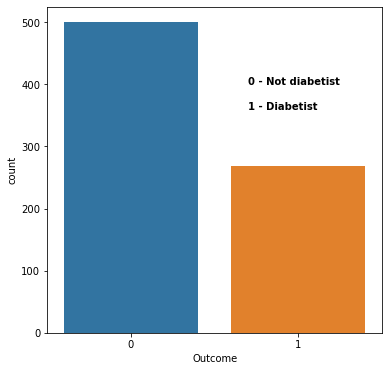

In [10]:
fig = plt.figure(figsize=(6,6))
sns.countplot(x=df['Outcome'], data=df)
plt.text(0.7, 400, "0 - Not diabetist", horizontalalignment='left', size='medium', color='black', weight='semibold')
plt.text(0.7, 360, "1 - Diabetist", horizontalalignment='left', size='medium', color='black', weight='semibold')
plt.show(block=True)

#### Distribution of remaining data

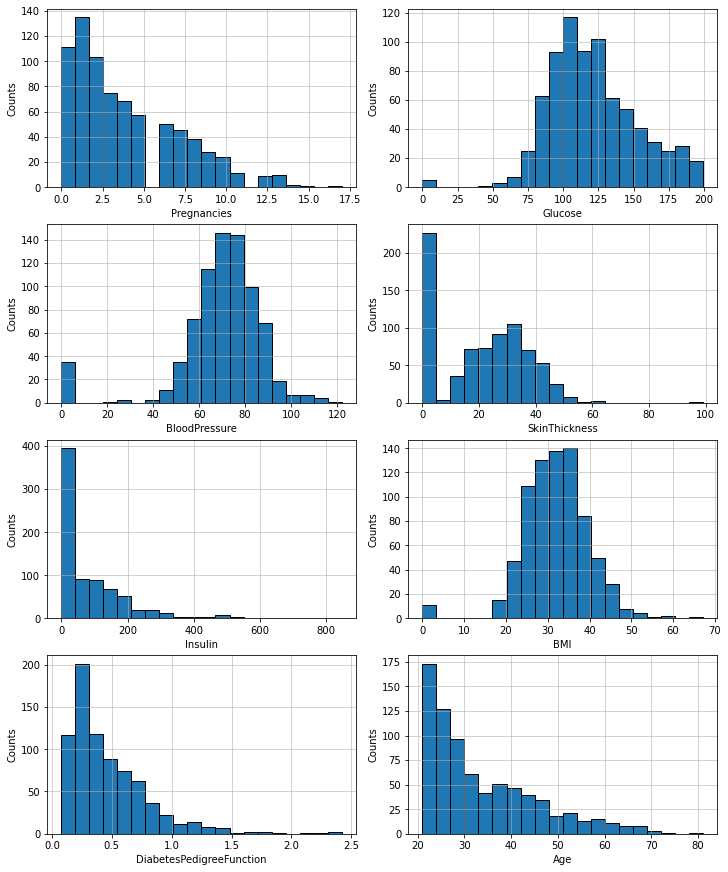

In [11]:
histograms_df(df,display_last_col=False)

The data from  *Glucose, Blood Pressure, Skin Thickness, Insulin* and *BMI* column, have zero values, which seem to be some kind of error or lack of data. The data will be supplemented in next step.

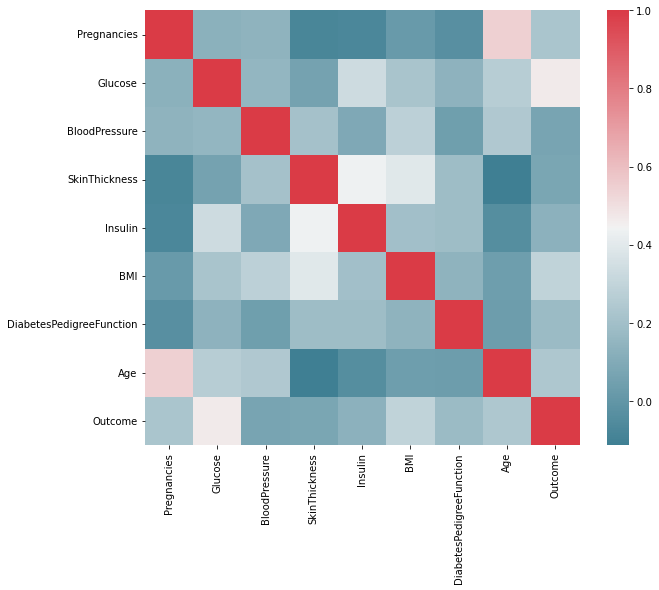

In [12]:
f, ax = plt.subplots(figsize=(10, 8))
corr = df.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=bool),
            cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax);

The plot shows that there is no highly correlated data.

#### Modeling

In [13]:
y=df["Outcome"]
X=df.drop(["Outcome"], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.33, random_state=1)

inputer=SimpleImputer(missing_values=0, strategy='median')

pipeline=Pipeline([
('inputer', SimpleImputer(missing_values=0, strategy='median')),
('std_scaler', StandardScaler())
])

X_train_imp=pipeline.fit_transform(X_train)
X_test_imp=pipeline.transform(X_test)

X_train_imp=pd.DataFrame(X_train_imp,columns=X_train.columns,index=X_train.index)
X_test_imp=pd.DataFrame(X_test_imp,columns=X_test.columns,index=X_test.index)

In [14]:
model = LogisticRegression(random_state=1)
model.fit(X_train_imp, y_train)

LogisticRegression(random_state=1)

In [15]:
y_pred = model.predict(X_test_imp)
y_prob = model.predict_proba(X_test_imp)[:, 1]

In [16]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.90      0.84       162
           1       0.76      0.57      0.65        92

    accuracy                           0.78       254
   macro avg       0.77      0.73      0.74       254
weighted avg       0.78      0.78      0.77       254



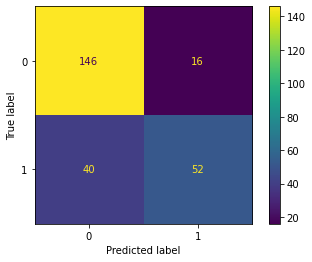

In [17]:
cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=model.classes_)
disp.plot()
plt.show()

* The simple logistic regression model preform fairly good with detection of cases without diabetes (class 0). The number of false positive predictions is low.
* The model shows large number of false negative predictions.
* If the diabetes detection is essential, the model should be modify in order to predict more diabetes cases with limited number of false detections.
